# ARIMA를 통해 주가 예측에 도전! 

In [1]:
import pandas
import sklearn
import statsmodels

print(pandas.__version__)
print(sklearn.__version__)
print(statsmodels.__version__)

1.3.3
1.0
0.13.0


In [2]:
pip install yfinance -qq

Note: you may need to restart the kernel to use updated packages.


### Visa 의 주식데이터를 yfinance를 이용해 가져온다

In [3]:
import yfinance as yf

stock = 'V'

df = yf.download(stock, start="2020-02-21", end="2024-02-27")

[*********************100%%**********************]  1 of 1 completed


In [4]:
df.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2024-02-20,274.570007,276.839996,273.339996,275.149994,275.149994,6157200
2024-02-21,274.630005,276.970001,273.529999,276.760010,276.760010,4771100
2024-02-22,279.179993,284.059998,278.980011,283.750000,283.750000,5100200
2024-02-23,284.720001,285.950012,283.500000,283.600006,283.600006,5107100
2024-02-26,283.040009,285.350006,282.660004,284.149994,284.149994,3856900


# 1. 시계열 데이터 준비
- 칼럼 종류: Date, Open, High, Low, Close, Adj Close, Volume
- 날짜별로 시작가(Open), 최고가(High), 최저가(Low), 종가(Close), 수정종가(Adj Close), 거래량(Volume)이 저장되어 있는 것을 확인할 수 있습니다.
- 우리는 종가(Close)만 사용하겠습니다. (주식 시장은 정해진 시간 동안만 거래가 가능합니다. 종가란 하루의 장이 마감하였을 때의 가격입니다.)

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [6]:
ts = df['Close']

In [7]:
ts.head()

Date
2020-02-21    208.809998
2020-02-24    198.789993
2020-02-25    188.399994
2020-02-26    187.210007
2020-02-27    180.009995
Name: Close, dtype: float64

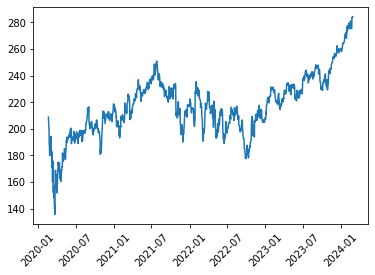

In [8]:
plt.plot(ts)
plt.xticks(rotation=45);

# 2. 각종 전처리 수행
- 결측치 처리
- 로그 변환

In [9]:
# 결측치 처리
ts = ts.interpolate(method='time')
ts[ts.isna()]# Time Series에서 결측치가 있는 부분만 Series로 출력합니다.

Series([], Name: Close, dtype: float64)

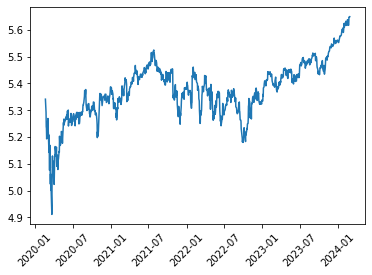

In [10]:
# 로그 변환
ts_log = np.log(ts)
plt.plot(ts_log)
plt.xticks(rotation=45);

# 3. 시계열 안정성 분석
- 정성적 그래프 분석
- 정량적 Augmented Dicky-Fuller Test
- 시계열 분해(Time Series Decomposition)
- Residual 안정성 확인

In [11]:
def plot_rolling_statistics(timeseries, window=12):
    rolmean = timeseries.rolling(window=window).mean()
    rolstd = timeseries.rolling(window=window).std()
    
    original = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling mean')
    std = plt.plot(rolstd, color='green', label='Rolling std')
    plt.legend(loc='best')
    plt.title('Rolling mean & std')
    plt.show(block=False)

* plt.legend(loc='best') : 범례의 위치를 자동으로 최적의 위치로 설정하라

In [12]:
from statsmodels.tsa.stattools import adfuller

def augmented_dickey_fuller_test(timeseries):
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # adfuller 메서드가 리턴한 결과를 정리하여 출력합니다.
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

- 'Autolag'는 Augmented Dickey-Fuller (ADF) 테스트와 같은 시계열 분석을 수행할 때 사용되는 옵션 중 하나
- AIC(Akaike Information Criterion)s : 모델의 상대적 품질을 평가하는 통계적 지표
- AIC는 모델이 데이터를 잘 설명하는 데 필요한 변수의 수와 모델의 적합도를 고려하여 모델을 선택하는 데 사용됩니다.
- 'Autolag'를 'AIC'로 설정하면 AIC를 기준으로 최적의 시차(lag)를 자동으로 선택하게 됩니다.
- 이를 통해 시계열 데이터의 정상성(stationarity)을 테스트하는 데 사용되는 ADF 테스트의 성능을 향상시킬 수 있습니다.

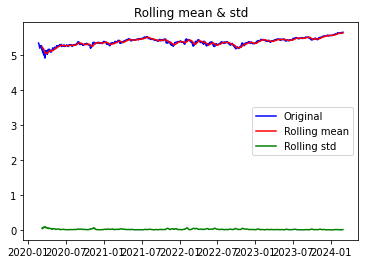

Results of Dickey-Fuller Test:
Test Statistic                  -1.563028
p-value                          0.502134
#Lags Used                      15.000000
Number of Observations Used    994.000000
Critical Value (1%)             -3.436946
Critical Value (5%)             -2.864452
Critical Value (10%)            -2.568321
dtype: float64


In [13]:
# 정성적 그래프 분석
plot_rolling_statistics(ts_log, window=12)

#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

* p-value > 0.05, 그리고 test statistics > critical values이므로 정상성을 띠지 않는다.

# (추가) 이동평균 한번 구해보기

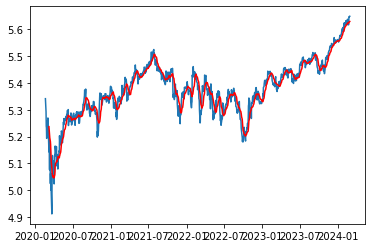

In [14]:
moving_avg = ts_log.rolling(window=12).mean()  # moving average구하기 
plt.plot(ts_log)
plt.plot(moving_avg, color='red')

In [15]:
ts_log_moving_avg = ts_log - moving_avg # 변화량 제거
ts_log_moving_avg.head(15)

Date
2020-02-21         NaN
2020-02-24         NaN
2020-02-25         NaN
2020-02-26         NaN
2020-02-27         NaN
2020-02-28         NaN
2020-03-02         NaN
2020-03-03         NaN
2020-03-04         NaN
2020-03-05         NaN
2020-03-06         NaN
2020-03-09   -0.094513
2020-03-10   -0.018461
2020-03-11   -0.061153
2020-03-12   -0.124907
Name: Close, dtype: float64

In [16]:
ts_log_moving_avg.dropna(inplace=True)
ts_log_moving_avg.head(5)

Date
2020-03-09   -0.094513
2020-03-10   -0.018461
2020-03-11   -0.061153
2020-03-12   -0.124907
2020-03-13   -0.025837
Name: Close, dtype: float64

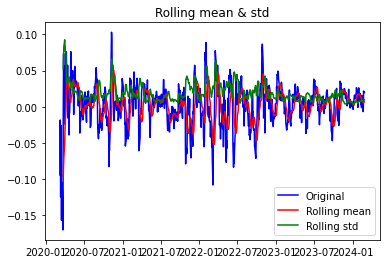

In [17]:
plot_rolling_statistics(ts_log_moving_avg)

In [18]:
augmented_dickey_fuller_test(ts_log_moving_avg)

Results of Dickey-Fuller Test:
Test Statistic                -1.154597e+01
p-value                        3.540551e-21
#Lags Used                     5.000000e+00
Number of Observations Used    9.930000e+02
Critical Value (1%)           -3.436953e+00
Critical Value (5%)           -2.864455e+00
Critical Value (10%)          -2.568322e+00
dtype: float64


* p-value < 0.05 이므로 귀무가설(시계열이 비정상이다) 기각. 시계열은 정상성을 띤다고 판별. 

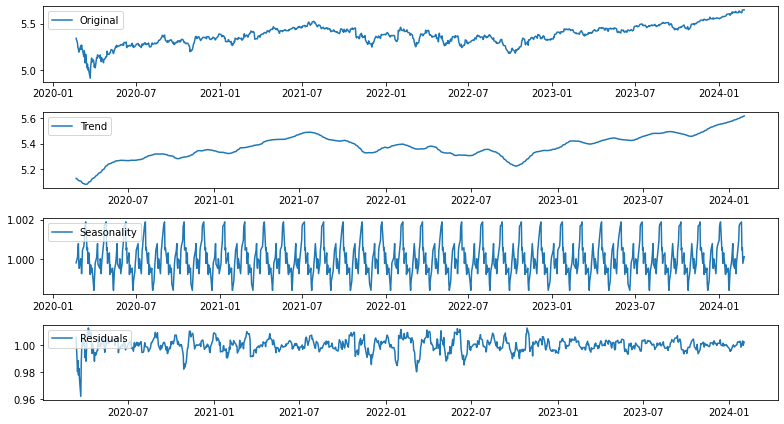

In [19]:
#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30)

trend = decomposition.trend # 추세(시간 추이에 따라 나타나는 평균값 변화 )
seasonal = decomposition.seasonal # 계절성(패턴이 파악되지 않은 주기적 변화)
residual = decomposition.resid # 원본(로그변환한) - 추세 - 계절성

plt.rcParams["figure.figsize"] = (11,6)

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='upper left')

plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='upper left')

plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='upper left')

plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='upper left')

plt.tight_layout()

In [20]:
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -9.683869e+00
p-value                        1.184781e-16
#Lags Used                     1.600000e+01
Number of Observations Used    9.630000e+02
Critical Value (1%)           -3.437159e+00
Critical Value (5%)           -2.864546e+00
Critical Value (10%)          -2.568371e+00
dtype: float64


# 4. 학습, 테스트 데이터셋 생성

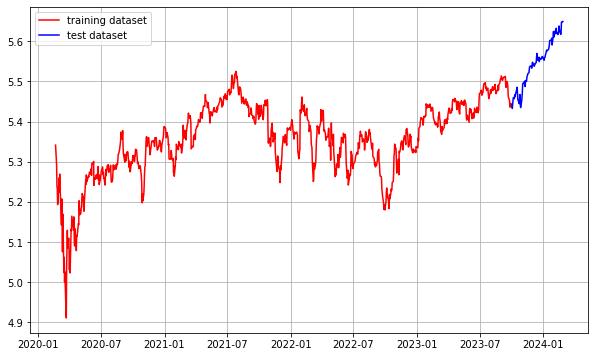

In [21]:
train_data, test_data = ts_log[:int(len(ts_log) * 0.9)], ts_log[int(len(ts_log)*0.9):] 

plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(train_data, c='r', label='training dataset')
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

* 빨간애가 (90%) train, 파란애가 (10%) test data로 배정되었다

# 5. 적정 ARIMA 모수(parameter) 찾기
- ACF, PACF 그려보기 -> p,q 구하기
- 차분 안정성 확인 -> d 구하기

/opt/conda/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


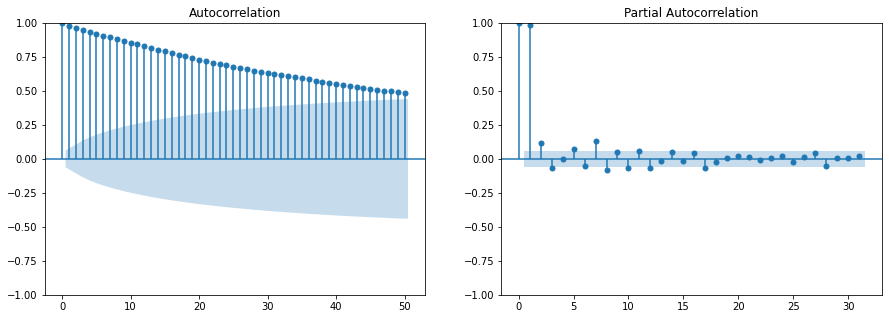

In [22]:
# ACF, PACF 그려보기 -> p,q 구하기
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

max_lag = 50

fig, axes = plt.subplots(1,2,figsize=(15,5))
plot_acf(ts_log, ax=axes[0], lags=max_lag)
plot_pacf(ts_log, ax=axes[1])
plt.show()

- 아래 표를 참고하면 AR(자기회귀)모델을 MA(이동평균)모델을 할지 정할 수 있다
- ACF그래프는 점점 작아지고, PACF그래프는 두번째 그래프 이상에서는 끊기기 때문에
- AR(자기회귀) 모델을 쓰는 것이 적절해 보인다
- max_lag 함수를 통해 ACF의 lag수를 늘려줄 수 있다

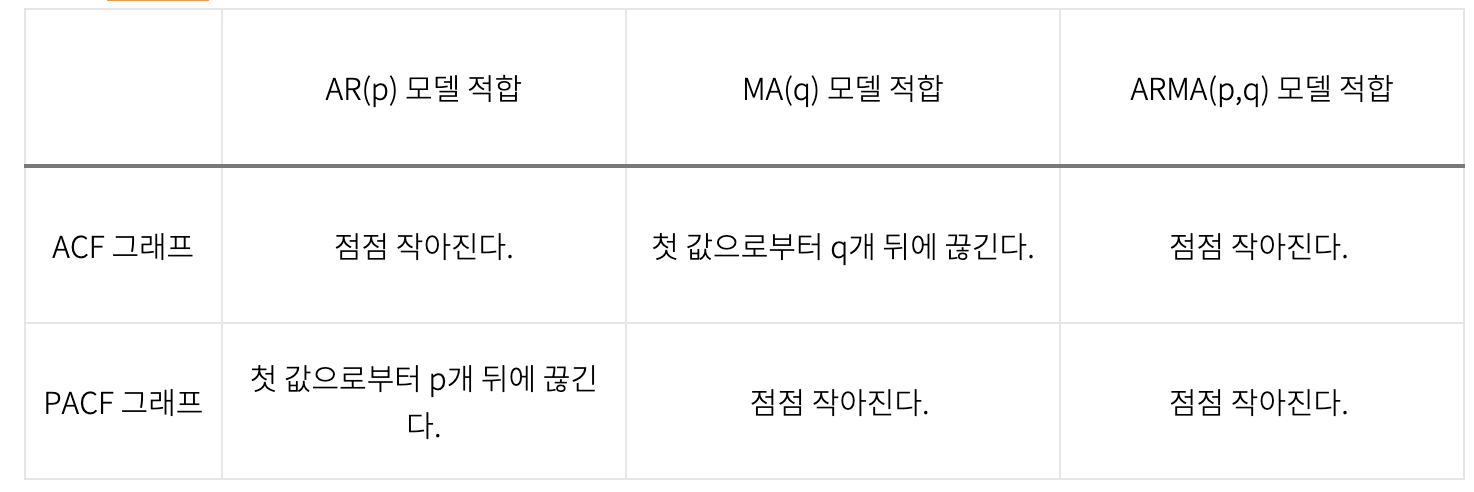

Results of Dickey-Fuller Test:
Test Statistic                -9.576793e+00
p-value                        2.212338e-16
#Lags Used                     1.400000e+01
Number of Observations Used    9.940000e+02
Critical Value (1%)           -3.436946e+00
Critical Value (5%)           -2.864452e+00
Critical Value (10%)          -2.568321e+00
dtype: float64


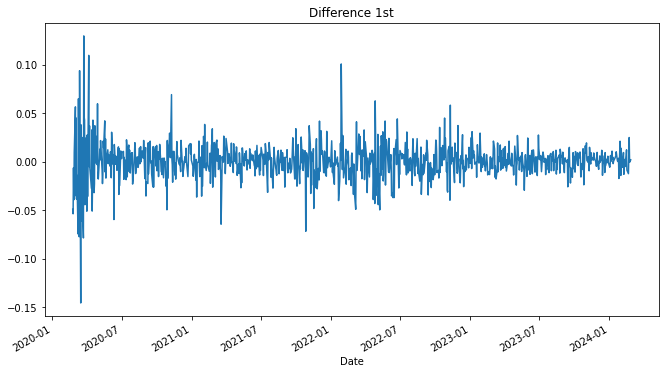

In [23]:
# 차분 안정성 확인 -> d 구하기
#1차 차분

diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title = 'Difference 1st')

augmented_dickey_fuller_test(diff_1)

* 1차 차분으로도 충분한 안정성을 보인다
- Test Statistics < Critical values 보다 작고
- P-value < 0.05 이므로 귀무가설 기각,  시계열 데이터는 안정적이다.

Results of Dickey-Fuller Test:
Test Statistic                -1.215674e+01
p-value                        1.525949e-22
#Lags Used                     2.200000e+01
Number of Observations Used    9.850000e+02
Critical Value (1%)           -3.437006e+00
Critical Value (5%)           -2.864479e+00
Critical Value (10%)          -2.568335e+00
dtype: float64


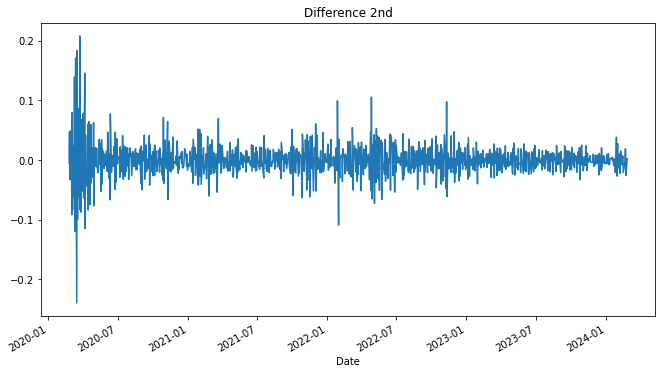

In [24]:
#2차 차분 구하기 (혹시 필요할까봐 그냥 해봄)
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title = 'Difference 2nd')

augmented_dickey_fuller_test(diff_2)

# 6. ARIMA 모델 훈련과 테스트
- ARIMA 모델 빌드와 훈련
- 모델 테스트 및 플로팅
- 최종 예측 모델 정확도 측정(MAPE)

In [25]:
import warnings
warnings.filterwarnings('ignore')

from statsmodels.tsa.arima.model import ARIMA

# Build and Train  Model
model = ARIMA(train_data, order=(40, 1, 0))
fitted_m = model.fit()
print(fitted_m.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  909
Model:                ARIMA(40, 1, 0)   Log Likelihood                2341.291
Date:                Thu, 29 Feb 2024   AIC                          -4600.582
Time:                        09:28:19   BIC                          -4403.321
Sample:                             0   HQIC                         -4525.259
                                - 909                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0891      0.026     -3.383      0.001      -0.141      -0.037
ar.L2          0.0365      0.027      1.337      0.181      -0.017       0.090
ar.L3          0.0112      0.034      0.333      0.7

* 시각화

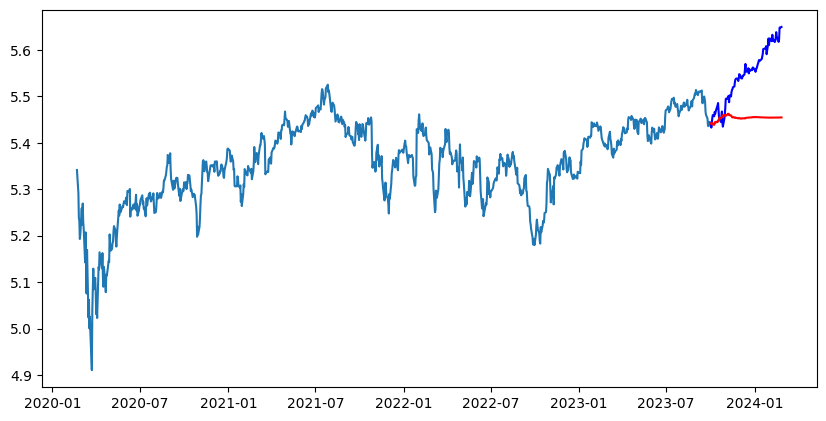

In [26]:

# Forecast : 결과가 fc에 담깁니다. 
fc = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)
# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')

* ARIMA 모델의 'order' 매개변수 : AR(Auto-Regressive), 차분(Differencing), MA(Moving Average) 구성을 지정
- 각각 모델의 자기 회귀(AR), 차분(차수를 나타냄), 이동 평균(MA) 부분을 나타냄
  
  
- AR(Auto-Regressive) order (p): 이전 관측치의 선형 가중 합으로 현재 관측치를 예측하는 데 사용되는 시차(lag)의 수
- 차분(Differencing) order (d): 시계열 데이터에 대한 차분(Differencing)의 차수를 나타냅니다. 데이터를 정상 상태로 만들기 위해 필요한 차분 수
- MA(Moving Average) order (q): 이동 평균 모형의 차수로, 이전 예측 오차의 선형 가중 합으로 현재 관측치를 예측하는 데 사용되는 시차(lag)의 수


* forecast() 메소드를 이용해 학습된 ARIMA 모델을 사용하여 테스트 데이터 구간에 대한 예측을 수행
* len(test_data)는 예측할 데이터 포인트의 수를 지정하고, alpha=0.05는 신뢰 구간을 설정하는데 사용되는 알파 값으로, 95%의 신뢰 수준을 나타낸다. 이 예측값을 fc에 저장한다

In [27]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  733.9133304790876
MAE:  22.76415644009671
RMSE:  27.09083480587277
MAPE: 8.58%


- np.exp()를 통해 전부 원본 스케일로 돌린 후 MSE, MAE, RMSE, MAPE를 계산했다
- MAPE가 8.58%로 성능이 그리 좋지 않다. 다른 주식들로 다시 해본다.

# 7. 다른 주식 종목 예측해 보기

## 1) S&P500 (SPDR)

[*********************100%%**********************]  1 of 1 completed


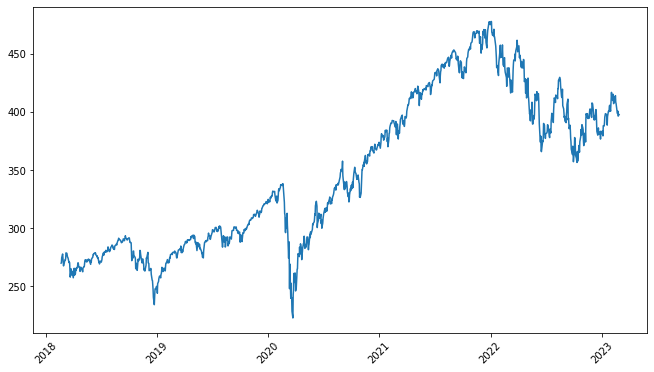

In [28]:
stock = 'SPY'

df = yf.download(stock, start="2018-02-21", end="2023-02-28")
ts = df['Close']
plt.plot(ts)
plt.xticks(rotation=45);

In [29]:
ts = ts.interpolate(method='time')
ts[ts.isna()]

Series([], Name: Close, dtype: float64)

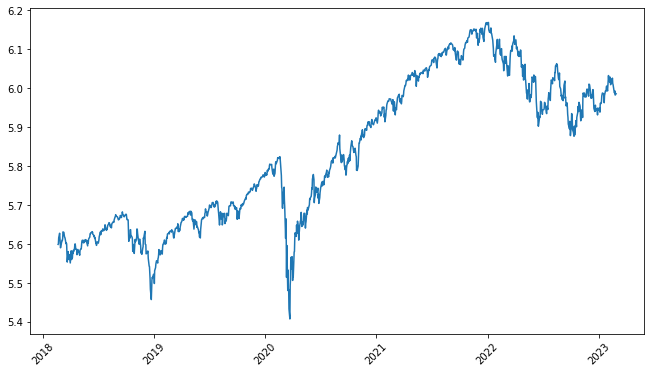

In [30]:
# 로그 변환
ts_log = np.log(ts)
plt.plot(ts_log)
plt.xticks(rotation=45);

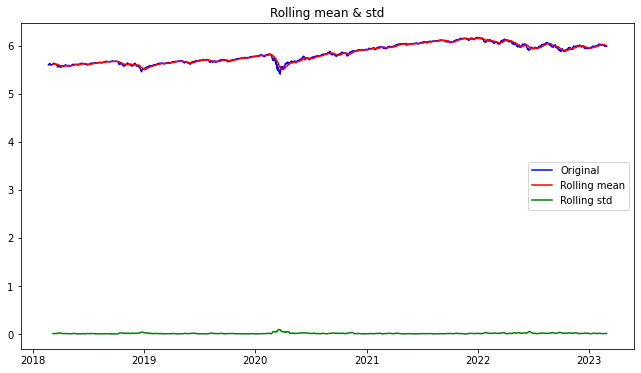

Results of Dickey-Fuller Test:
Test Statistic                   -1.429027
p-value                           0.568284
#Lags Used                        9.000000
Number of Observations Used    1253.000000
Critical Value (1%)              -3.435580
Critical Value (5%)              -2.863849
Critical Value (10%)             -2.568000
dtype: float64


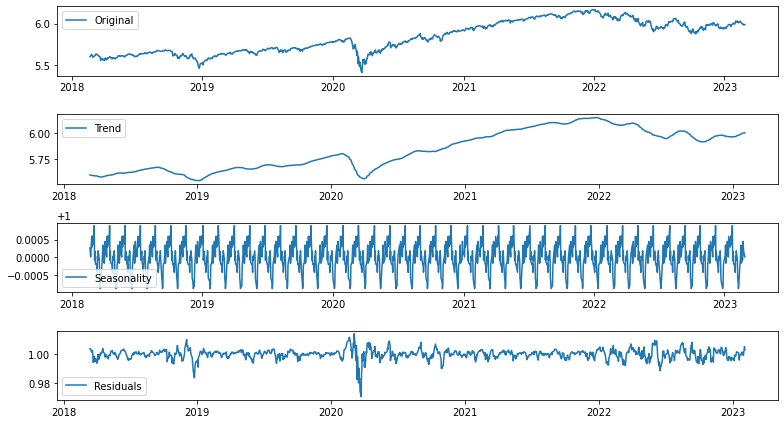

In [31]:
# 정성적 그래프 분석
plot_rolling_statistics(ts_log, window=12)

#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [32]:
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -1.047282e+01
p-value                        1.271256e-18
#Lags Used                     2.100000e+01
Number of Observations Used    1.211000e+03
Critical Value (1%)           -3.435761e+00
Critical Value (5%)           -2.863930e+00
Critical Value (10%)          -2.568042e+00
dtype: float64


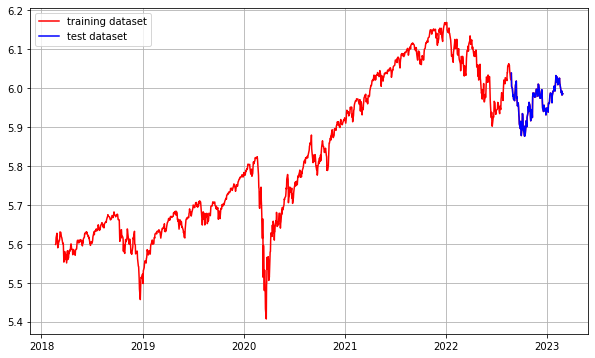

In [33]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

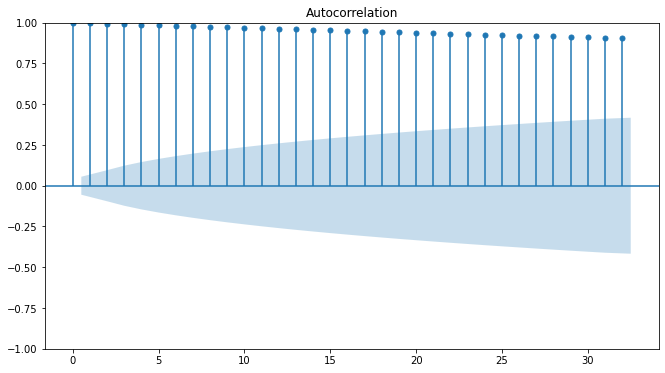

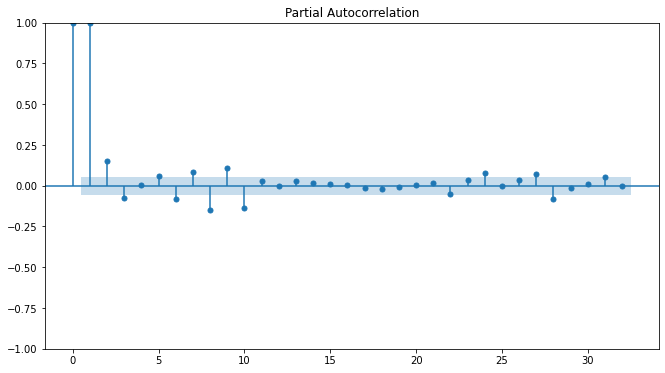

In [34]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                -1.065062e+01
p-value                        4.671628e-19
#Lags Used                     8.000000e+00
Number of Observations Used    1.253000e+03
Critical Value (1%)           -3.435580e+00
Critical Value (5%)           -2.863849e+00
Critical Value (10%)          -2.568000e+00
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                -1.334200e+01
p-value                        5.894838e-25
#Lags Used                     1.900000e+01
Number of Observations Used    1.241000e+03
Critical Value (1%)           -3.435630e+00
Critical Value (5%)           -2.863872e+00
Critical Value (10%)          -2.568011e+00
dtype: float64


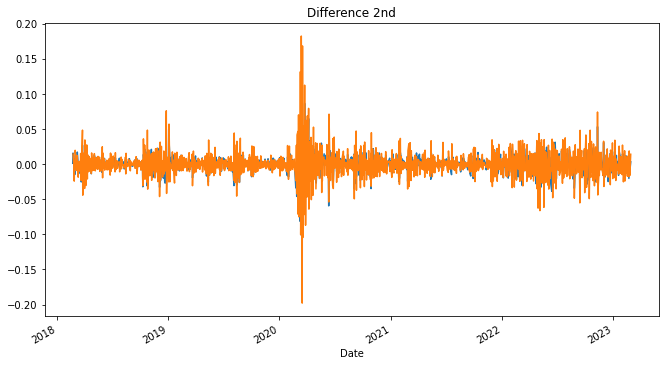

In [35]:
# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

# 혹시 필요한 경우 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

In [36]:
from statsmodels.tsa.arima.model import ARIMA
# Build Model
model = ARIMA(train_data, order=(2, 0, 1))  
fitted_m = model.fit() 

print(fitted_m.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 1136
Model:                 ARIMA(2, 0, 1)   Log Likelihood                3293.682
Date:                Thu, 29 Feb 2024   AIC                          -6577.364
Time:                        09:28:26   BIC                          -6552.188
Sample:                             0   HQIC                         -6567.855
                               - 1136                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.8129      0.059     98.659      0.000       5.697       5.928
ar.L1          0.4475      0.048      9.329      0.000       0.353       0.541
ar.L2          0.5453      0.047     11.521      0.0

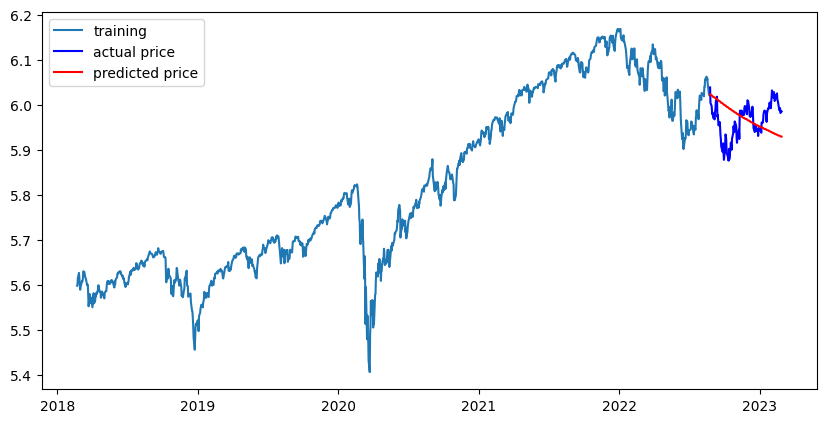

In [37]:
# Forecast : 결과가 fc에 담깁니다. 
fc = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)
# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()


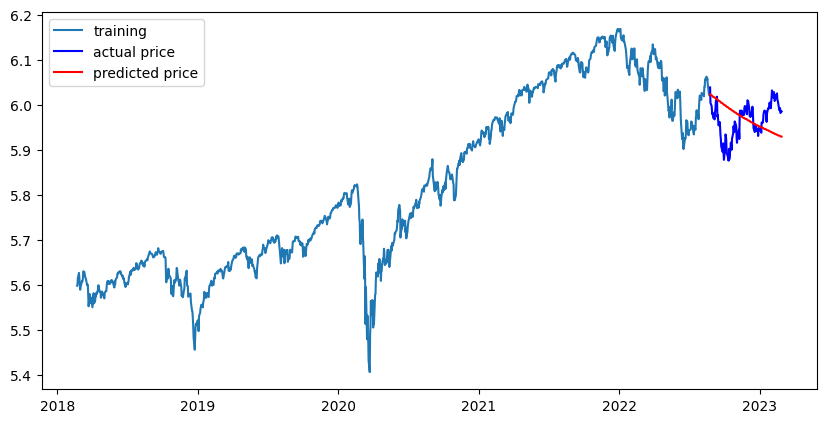

In [38]:
# Forecast : 결과가 fc에 담깁니다. 
fc = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)
# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

In [39]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  477.5085748340957
MAE:  18.03336440358405
RMSE:  21.851969587066876
MAPE: 4.67%


* MAPE 값이 4.67% 가 나왔다! 

# 3. AMZN

[*********************100%%**********************]  1 of 1 completed


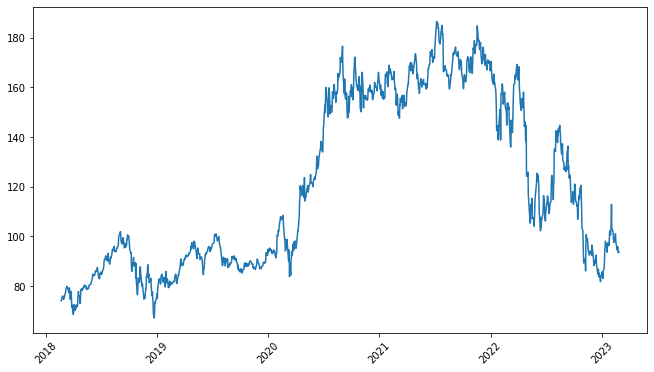

In [50]:
stock = 'AMZN'

df = yf.download(stock, start="2018-02-21", end="2023-02-28")
ts = df['Close']
plt.plot(ts)
plt.xticks(rotation=45);

In [51]:
ts = ts.interpolate(method='time')
ts[ts.isna()]
ts_log = np.log(ts)

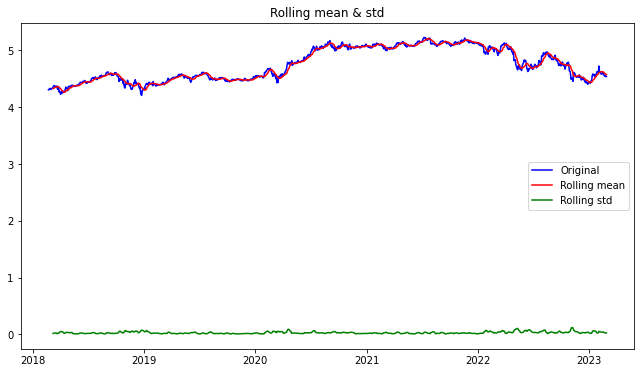

Results of Dickey-Fuller Test:
Test Statistic                   -1.739511
p-value                           0.410879
#Lags Used                        0.000000
Number of Observations Used    1262.000000
Critical Value (1%)              -3.435542
Critical Value (5%)              -2.863833
Critical Value (10%)             -2.567991
dtype: float64


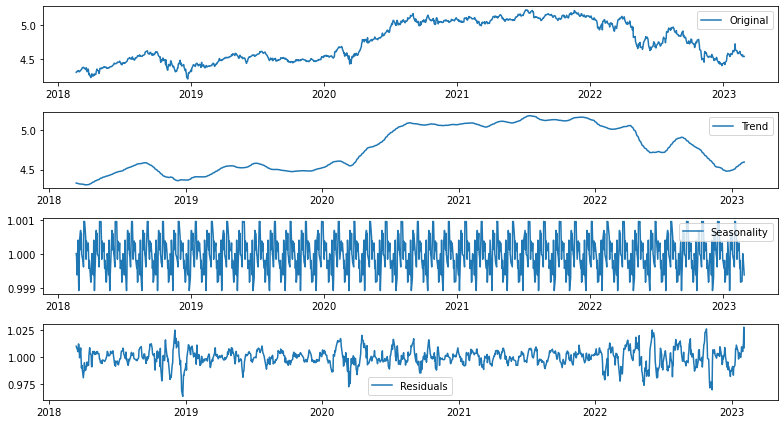

In [52]:
# 정성적 그래프 분석
plot_rolling_statistics(ts_log, window=12)

#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

* 데이터가 정상성을 띠지 않는다. p-value > 0.05 이다. 정상 띠도록 수정해준다.

Results of Dickey-Fuller Test:
Test Statistic                  -36.703716
p-value                           0.000000
#Lags Used                        0.000000
Number of Observations Used    1261.000000
Critical Value (1%)              -3.435546
Critical Value (5%)              -2.863835
Critical Value (10%)             -2.567992
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                -1.283487e+01
p-value                        5.769234e-24
#Lags Used                     2.100000e+01
Number of Observations Used    1.239000e+03
Critical Value (1%)           -3.435639e+00
Critical Value (5%)           -2.863876e+00
Critical Value (10%)          -2.568013e+00
dtype: float64


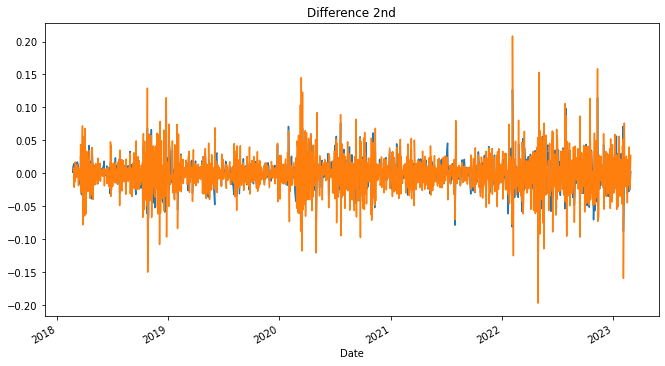

In [53]:
# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:] #1번 데이터는 Null이 될테니까
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

# 혹시 필요한 경우 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

* 1차 차분을 했을 때 데이터가 정상성을 띰을 확인했다.

In [54]:
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -1.094256e+01
p-value                        9.217366e-20
#Lags Used                     1.900000e+01
Number of Observations Used    1.213000e+03
Critical Value (1%)           -3.435752e+00
Critical Value (5%)           -2.863926e+00
Critical Value (10%)          -2.568040e+00
dtype: float64


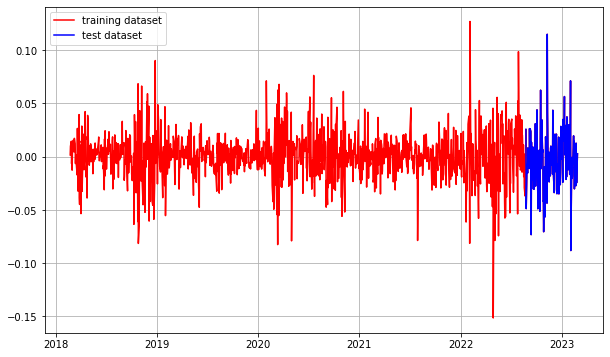

In [55]:
train_data, test_data = diff_1[:int(len(diff_1)*0.9)], diff_1[int(len(diff_1)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(diff_1, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

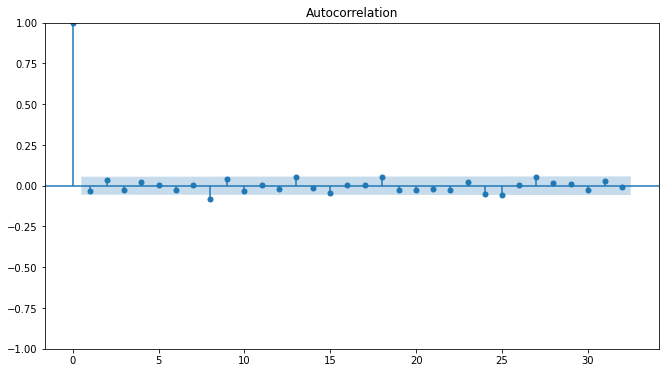

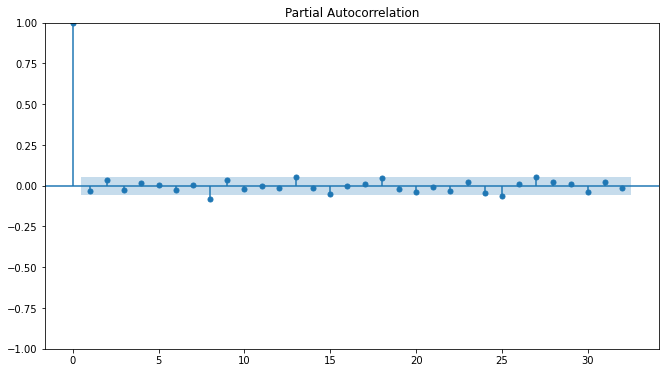

In [56]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(diff_1)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(diff_1)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

In [57]:
from statsmodels.tsa.arima.model import ARIMA
# Build Model
model = ARIMA(train_data, order=(2, 0, 1))  
fitted_m = model.fit() 

print(fitted_m.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 1135
Model:                 ARIMA(2, 0, 1)   Log Likelihood                2723.273
Date:                Thu, 29 Feb 2024   AIC                          -5436.546
Time:                        09:35:13   BIC                          -5411.374
Sample:                             0   HQIC                         -5427.038
                               - 1135                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0005      0.001      0.771      0.441      -0.001       0.002
ar.L1         -0.0212      0.694     -0.031      0.976      -1.380       1.338
ar.L2          0.0333      0.039      0.860      0.3

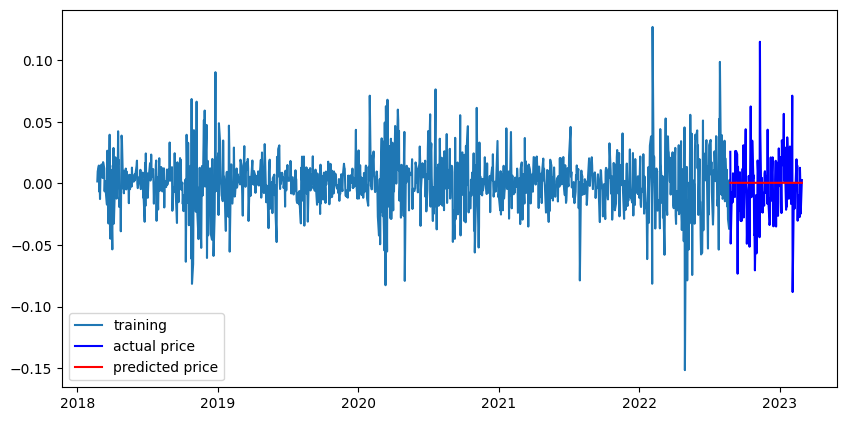

In [58]:
# Forecast : 결과가 fc에 담깁니다. 
fc = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)
# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

In [59]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  0.0008417511626542033
MAE:  0.021983947571499057
RMSE:  0.02901294818963084
MAPE: 2.21%


* MAPE 2.21% 로 낮아졌다. 데이터에 정상성을 부여하고 모델을 돌리니 확연히 좋아진다. 

# 회고
- ARIMA 모델 이름만 많이들어보고 실제로 다뤄본 적 없는데, 관심있는 다양한 주가 데이터를 가지고 시계열 데이터 예측 모델을 세워보니 재미있었습니다. 앞으로도 이쪽 분야에 관심이 많은데, 개인적으로도 열심히 공부해보고 싶다는 생각을 했습니다.
- residual data로 모델을 돌리지 않는 이유는, residual 데이터는 정상성을 판별하기 위한 목적이기 때문이라고 한다.
- 정상 데이터이느냐 아니느냐에 따라 MAPE값이 24%로 높게까지 올라가기도 했다. 데이터의 정상성을 파악하는 ADF, KPSS, ACF, PACF등을 자유자재로 사용하는 것이 매우 중요할 것 같다. 사용법을 잘 익혀야겠다.
- Time Series는 재밌다